In [ ]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
# from selenium import webdriver
from nltk.tokenize import word_tokenize
from fuzzywuzzy import fuzz

In [ ]:
df_train = pd.read_csv('/content/data/sentiment_analysis/train_data.csv')
df_test = pd.read_csv('/content/data/sentiment_analysis/test_data.csv')
df_title = pd.read_csv('/content/data/sentiment_analysis/title_brand.csv')

<div style="direction:rtl; font-size: 25px; background-color: cyan; color:black; padding:30px 0">  پیش پردازش داده </div>

In [5]:
### Convert to int16 to save memory
df_train['overall'] = df_train['overall'].astype('int16')
### Convert to datetime type
df_train['reviewTime'] =  pd.to_datetime(df_train['reviewTime'])
df_test['reviewTime'] =  pd.to_datetime(df_test['reviewTime'])
### Drop few rows so that data becomes cleaner (This is a minor change.)
df_train = df_train.dropna(subset=['summary', 'reviewerName', 'style'])
### Sort by datetime (reviewTime column)
df_train.sort_values(by='reviewTime', axis=0, inplace=True, ascending=True)
df_test.sort_values(by='reviewTime', axis=0, inplace=True, ascending=True)
### Max and Min date range
print(f"Max date : {df_train['reviewTime'].max()}")
print(f"Min date : {df_train['reviewTime'].min()}")

### Convert vote column
### For train
df_train['vote'] = pd.to_numeric(df_train['vote'], errors='coerce', downcast='integer')
df_train['vote'] = df_train['vote'].fillna(pd.NA).astype('Int32')
### For test
df_test['vote'] = pd.to_numeric(df_test['vote'], errors='coerce', downcast='integer')
df_test['vote'] = df_test['vote'].fillna(pd.NA).astype('Int32')

### reset index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

Max date : 2018-10-03 00:00:00
Min date : 2016-01-01 00:00:00


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490459 entries, 0 to 490458
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   overall         490459 non-null  int16         
 1   vote            110387 non-null  Int32         
 2   verified        490459 non-null  bool          
 3   reviewTime      490459 non-null  datetime64[ns]
 4   reviewerID      490459 non-null  object        
 5   asin            490459 non-null  object        
 6   style           490459 non-null  object        
 7   reviewerName    490459 non-null  object        
 8   reviewText      490459 non-null  object        
 9   summary         490459 non-null  object        
 10  unixReviewTime  490459 non-null  int64         
dtypes: Int32(1), bool(1), datetime64[ns](1), int16(1), int64(1), object(6)
memory usage: 33.7+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   vote            4933 non-null   Int32         
 1   verified        20000 non-null  bool          
 2   reviewTime      20000 non-null  datetime64[ns]
 3   reviewerID      20000 non-null  object        
 4   asin            20000 non-null  object        
 5   style           11504 non-null  object        
 6   reviewerName    19996 non-null  object        
 7   reviewText      20000 non-null  object        
 8   summary         19998 non-null  object        
 9   unixReviewTime  20000 non-null  int64         
dtypes: Int32(1), bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 1.3+ MB


<div style="direction:rtl; font-size: 25px; background-color: cyan; color:black; padding:30px 0"> بخش ۱) تجزیه و تحلیل اولیه از داده‌ها </div>

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت اول

<br>
<p>
توزیع ستون overall را رسم کنید. آیا مجموعه‌داده متوازن است؟ اگر خیر، آیا نیاز است برای مدل‌سازی خود آن را متوازن کنید؟ چه راه‌حلی برای این کار پیشنهاد می‌کنید؟
</p>

</div>

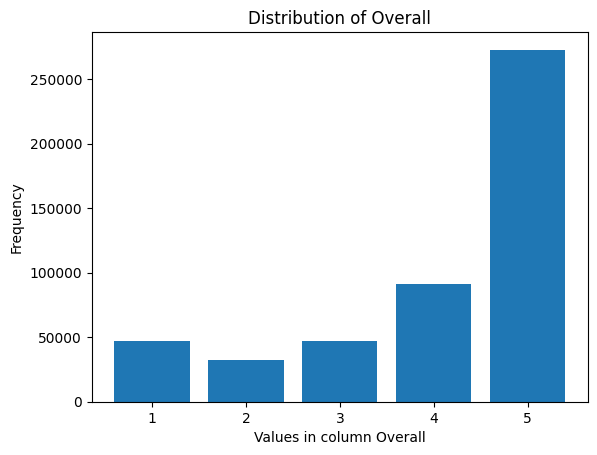

In [ ]:
### Plot distrubution of overall column
overall_values = df_train['overall'].value_counts().sort_index(ascending=False)
plt.xlabel('Values in column Overall')
plt.ylabel('Frequency')
plt.title('Distribution of Overall')
plt.bar(overall_values.index, overall_values.values)
plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت دوم

<br>
<p>
فرض کنید نظراتی که مقدار ستون overall آن‌ها ۴ یا ۵ است را همراه با حس مثبت، نظراتی که مقدارشان ۳ است را خنثی و نظراتی که مقدارشان ۱ یا ۲ است را حس منفی بدانیم. به‌ازای هر کدام از این سه دسته یک ابر کلمات (Word Cloud) رسم کنید تا بتوان کلمات پرتکرار هر دسته را مشاهده کرد. تا حد ممکن سعی کنید ابر کلمات به‌دست‌آمده شامل اطلاعات مفیدی باشد و کلمات زائد (Stop words) بین آن‌ها وجود نداشته باشد. آیا اشتراکی بین کلمات دسته‌ی مثبت و منفی وجود داشته است؟ چگونه آن‌ها را تفسیر می‌کنید؟
</p>




</div>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


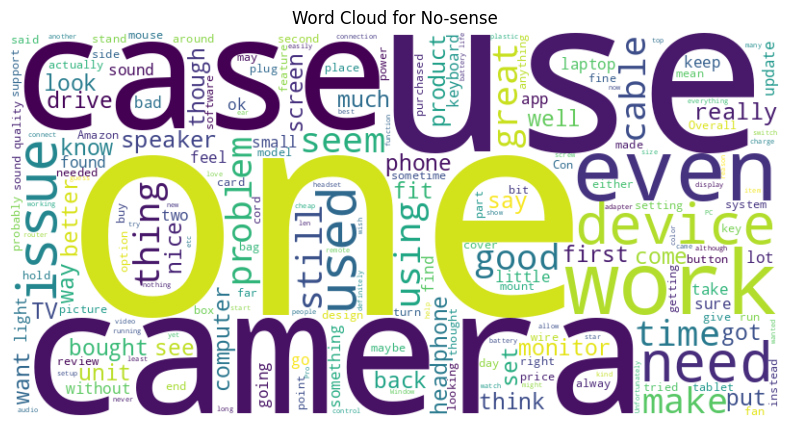

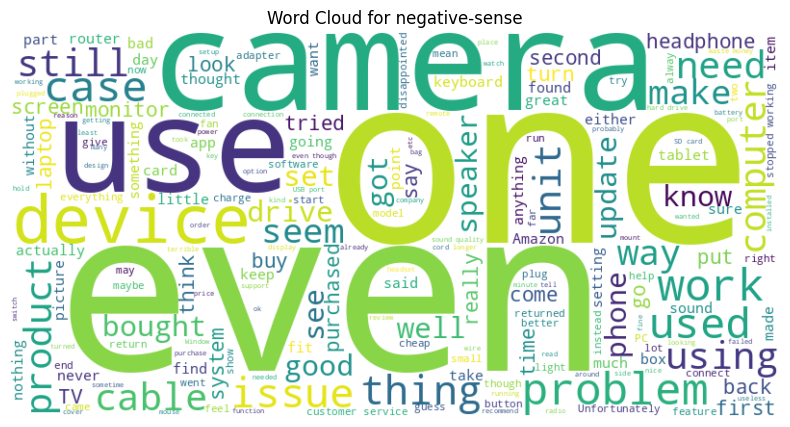

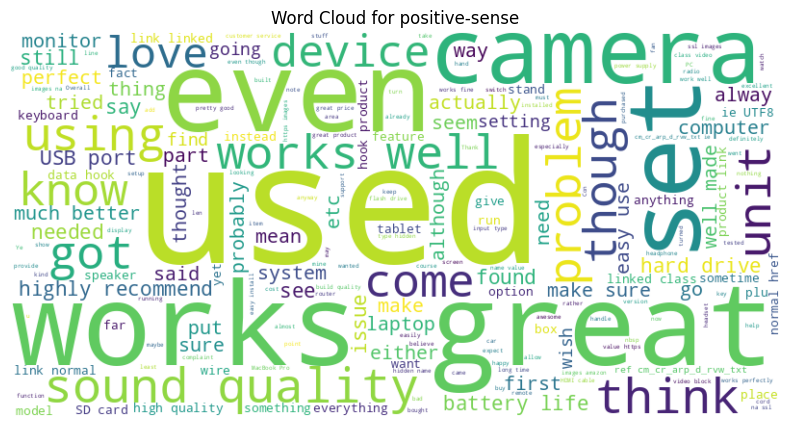

In [ ]:
# ### You only need to run this once . Uncomment it again afterwards.
nltk.download('stopwords')

### Define 3 groups
group_labels = {
    4: 'positive-sense',
    5: 'positive-sense',
    3: 'No-sense',
    2: 'negative-sense',
    1: 'negative-sense'
}
### Create a copy just to be sure
df_cloud = df_train.copy()

### Filter the DataFrame based on the custom group labels
df_cloud['group'] = df_cloud['overall'].map(group_labels)

### Just to be sure of results
### Filter out rows with no valid group
df = df_cloud[df_cloud['group'].notna()]

### Define a function to remove stop words from text string
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

### Apply remove_stopwords method to reviewText column
df_cloud['reviewText'] = df_cloud['reviewText'].apply(remove_stopwords)

### Plot word CLoud for each group
for group, data in df_cloud.groupby('group'):
    text = ' '.join(data['reviewText'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {group}')
    plt.axis('off')
    plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت سوم

<br>
<p>
از بین نظردهندگان، ۱۰ نفری که در مجموع نظرات‌شان بیشتر مفید واقع شده (مجموع vote بیشتری داشته‌اند) را پیدا کنید. نام هر فرد و مجموع vote آن را به‌ترتیب نمایش دهید.
</p>


</div>

In [ ]:
top_10_votes = df_train.sort_values(by='vote', ascending=False)
top_10_votes[['reviewerName', 'vote']].head(10)
### We kept original index in case for later reference

,reviewerName,vote
89312,David H,982
144823,VermontGuy,971
114660,Chris Upton,970
207819,Tech Dude,920
123268,R. Voorhees,919
44173,Obi Wan,909
76271,Benson Leung,889
366397,In Depth Reviewer - Xunno,831
49988,JBHorner,822
106123,N. Smith,819


<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت چهارم

<br>
<p>
هیستوگرام طول متن (تعداد کاراکتر) ستون reviewText را رسم کنید. یک‌بار با حالت اصلی رسم کنید و یک‌بار به‌صورت فیلترشده (آن دسته‌هایی که تعداد نمونه‌های کم و پرتی دارند را در نظر نگیرید) ترسیم کنید. انتخاب تعداد دسته‌ها (bins) برعهده‌ی خودتان است و نمودار خروجی شما باید مناسب و خوانا باشد. آیا نیاز است در هنگام مدل‌سازی محدودیتی روی تعداد کاراکترها بگذاریم؟ اگر بله، بازه‌ی پیشنهادی شما چه عددهایی است؟
</p>

</div>

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> حالت اصلی (بدون فیلتر) </div>

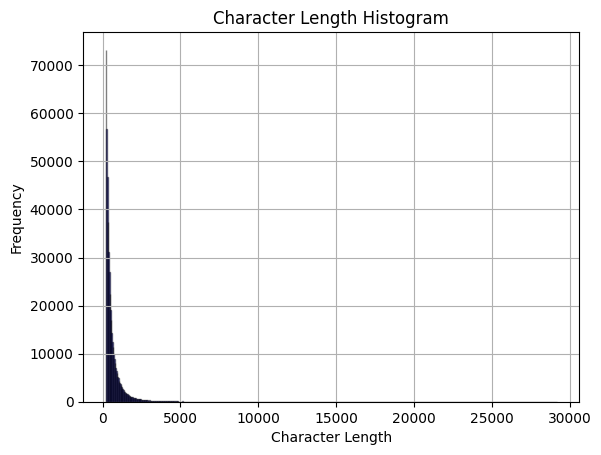

In [ ]:
### Calculate bins using square root
num_bins = int(np.sqrt(len(df_train['reviewText'])))
### Plot
plt.hist(df_train['reviewText'].apply(len), bins=num_bins, alpha=0.5, color='b', edgecolor='black')
plt.title('Character Length Histogram')
plt.xlabel('Character Length')
plt.ylabel('Frequency')

plt.grid(True)
plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> بعد از اعمال فیلتر </div>

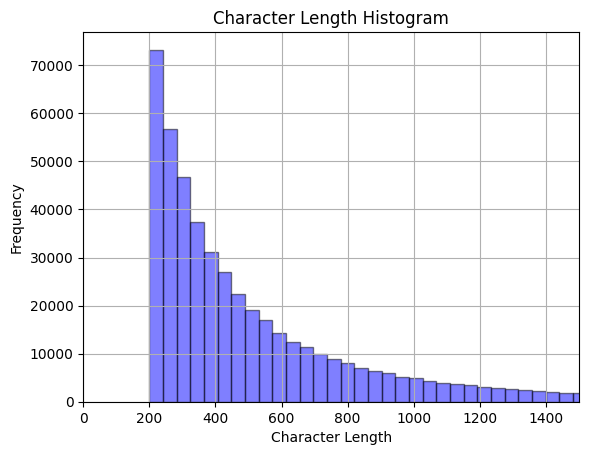

In [ ]:
### Calculate bins using square root
num_bins = int(np.sqrt(len(df_train['reviewText'])))
### Plot
plt.hist(df_train['reviewText'].apply(len), bins=num_bins, alpha=0.5, color='b', edgecolor='black')
plt.title('Character Length Histogram')
plt.xlabel('Character Length')
plt.ylabel('Frequency')

### Limit x-axis
plt.xlim(0, 1500)

plt.grid(True)
plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:white;"> با توجه به نمودار هیستوگرام بدست امده ، پیشنهاد میشود محدودیت 1500 تایی برای تعداد کاراکترهای نظرات در نظر گرفته شود چراکه اکثریت نظرات کمتر از این تعداد کاراکتر داشتند.  </div>

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت پنجم
<br>
<p>
کدام محصولات بیشترین امتیاز ۵ را کسب کرده‌اند؟ ۱۰ مورد برتر را به‌ترتیب به‌صورت یک جدول شامل نام برند، عنوان محصول و تعداد نظرات با امتیاز ۵ نمایش دهید
</p>
</div>

In [ ]:
### Groupby product string ID
top_10_products = df_train[df_train['overall'] == 5].groupby('asin').size().reset_index(name='count')
### Sort them by their count
top_10_products = top_10_products.sort_values(by='count', ascending=False)
top_10_products = top_10_products[:10].reset_index(drop=True)
top_10_products

,asin,count
0,B000VS4HDM,598
1,B00S9SGNNS,471
2,B000WYVBR0,448
3,B00P7EVST6,433
4,B00OAJ412U,430
5,B00DIF2BO2,428
6,B00JX1ZS5O,414
7,B00BWF5U0M,411
8,B003INFE16,400
9,B016XTADG2,400


In [ ]:
### Find both brand and title for each product
### If it exists in df_title.csv
for feature in ['brand', 'title']:
    found_features = []
    for pid in top_10_products['asin']:
        ### If it was found, add its feature
        if pid in df_title['asin'].values:
            found_feature = df_title[df_title['asin'] == pid ][feature].values[0]
            found_features.append(found_feature)
        ### If not found, add NaN instead
        else:
            found_features.append(pd.NA)
    ### Add brands to df
    top_10_products[feature.capitalize()] = found_features
top_10_products

,asin,count,Brand,Title
0,B000VS4HDM,598,StarTech,StarTech USB 2.0 to SATA IDE Adapter (USB2SATA...
1,B00S9SGNNS,471,Asus,ASUS Tri-Band Gigabit (AC3200) WiFi Router (Up...
2,B000WYVBR0,448,VideoSecu,VideoSecu ML531BE TV Wall Mount for Most 27&qu...
3,B00P7EVST6,433,"Arlo Technologies, Inc",Arlo - Wireless Home Security Camera System | ...
4,B00OAJ412U,430,Samsung,Samsung 850 EVO 250GB 2.5-Inch SATA III Intern...
5,B00DIF2BO2,428,Cheetah,Cheetah Mounts APFMSB TV Wall Mount Bracket fo...
6,B00JX1ZS5O,414,Sabrent,Sabrent 4-Port USB 3.0 Hub with Individual LED...
7,B00BWF5U0M,411,Sabrent,Sabrent 4-Port USB 2.0 Hub with Individual Pow...
8,B003INFE16,400,Cooler Master,Cooler Master Vortex Plus - CPU Cooler with Al...
9,B016XTADG2,400,Anker,Anker Soundcore Bluetooth Speaker with Loud St...


<div style="direction:rtl; font-size: 25px; background-color: green; color:black;">  

<p>
این قسمت را به صورت طرح مسیله جدید پیش بردیم و با اسکریپ کردن دیتا مستقیما از وبسایت آمازون ، برند محصولات را بدست اوردیم
</p>

<p>
به جای استفاده از فایل title_data.csv
(طرح مسیله جدید)
</p>


</div>

In [ ]:
from time import sleep
from selenium.webdriver.common.by import By
from webdriver_manager.firefox import GeckoDriverManager
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

driver = webdriver.Firefox()
brands_web = []
models_web = []



for product_id in top_10_products["asin"]:
    driver.get(f"https://www.amazon.com/dp/{product_id}")

    ### Model name
    model_name = driver.find_element(By.ID,'productTitle').text

    ### Brand name
    inner_html = "Brand"
    xpath_expression = f"//span[contains(., '{inner_html}')]"
    span_element = driver.find_element(By.XPATH,xpath_expression)
    parent_element = span_element.find_element(By.XPATH,'..')
    sibling_element = parent_element.find_element(By.XPATH,'following-sibling::*')
    child_element = sibling_element.find_element(By.XPATH,'.//*')
    inner_html = child_element.get_attribute('innerHTML')
    brand_name = inner_html

    try:
        pass
    except NoSuchElementException:
        button = driver.find_element_by_xpath('/html/body/div[1]/header/div/div[4]/div[1]/div/div/div[3]/span[1]/span/input')
        button.click()

    brands_web.append(brand_name)
    models_web.append(model_name)

    sleep(3)
driver.quit()

In [ ]:
top_10_products['Brand_web'] = brands_web
top_10_products['Model_web'] = models_web
top_10_products.rename(columns={'asin': 'Product_id', 'count': 'No_5_star_Reviews'}, inplace=True)
top_10_products

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت ششم

<br>
<p>
ابتدا ۱۰ برندی که بیشترین تعداد نظر را داشته‌اند پیدا کنید. سپس میانگین امتیاز هرکدام را محاسبه کرده و یک جدول شامل نام برند و میانگین امتیاز آن به‌ترتیب میانگین امتیاز نمایش دهید.
</p>

</div>

</div>

In [ ]:
### First get top 10 products with most reviews
top_10_reviews = df_train.groupby(by='asin').agg({'asin': 'count'}).rename_axis('Product_id').sort_values(by='asin', ascending=False)[:10].reset_index()
top_10_reviews.rename(columns={'asin': 'Total_Reviews'}, inplace=True)
### Then calculate average overall rating for top 10 products with most reviews
means = []
for pid in top_10_reviews['Product_id']:
    average = df_train[df_train['asin'] == pid]['overall'].mean()
    means.append(average)
### Add averages to top_10_reviews
top_10_reviews['Mean_Overall'] = means
top_10_reviews

,Product_id,Total_Reviews,Mean_Overall
0,B00P7EVST6,1114,3.657092
1,B00S9SGNNS,905,3.690608
2,B000VS4HDM,793,4.403531
3,B00BUSDVBQ,760,3.730263
4,B00JX1ZS5O,759,4.005270
5,B01BGTG41W,747,3.583668
6,B00DIF2BO2,737,4.179104
7,B006JH8T3S,682,4.102639
8,B000WYVBR0,672,4.316964
9,B003Y5RYNY,670,3.807463


In [ ]:
### Get only brand this time. (No title needed)
for feature in ['brand']:
    found_features = []
    for pid in top_10_reviews['Product_id']:
        ### If it was found, add its feature
        if pid in df_title['asin'].values:
            found_feature = df_title[df_title['asin'] == pid ][feature].values[0]
            found_features.append(found_feature)
        ### If not found, add NaN instead
        else:
            found_features.append(pd.NA)
    ### Add brands to df
    top_10_reviews[feature.capitalize()] = found_features
### Sort by Mean_Overall
top_10_reviews.sort_values(by='Mean_Overall', ascending=False,inplace=True)
top_10_reviews.reset_index(drop=True, inplace=True)
top_10_reviews

,Product_id,Total_Reviews,Mean_Overall,Brand
0,B000VS4HDM,793,4.403531,StarTech
1,B000WYVBR0,672,4.316964,VideoSecu
2,B00DIF2BO2,737,4.179104,Cheetah
3,B006JH8T3S,682,4.102639,Logitech
4,B00JX1ZS5O,759,4.005270,Sabrent
5,B003Y5RYNY,670,3.807463,TP-LINK
6,B00BUSDVBQ,760,3.730263,TP-LINK
7,B00S9SGNNS,905,3.690608,Asus
8,B00P7EVST6,1114,3.657092,"Arlo Technologies, Inc"
9,B01BGTG41W,747,3.583668,SanDisk


<div style="direction:rtl; font-size: 25px; background-color: green; color:black;">  

<p>
این قسمت را به صورت طرح مسیله جدید پیش بردیم و با اسکریپ کردن دیتا مستقیما از وبسایت آمازون ، برند محصولات را بدست اوردیم
</p>

<p>
به جای استفاده از فایل title_data.csv
(طرح مسیله جدید)
</p>


</div>

In [ ]:
### Finally get their brands from web
brands_web_2 = []
for p_id in top_10_reviews['Product_id']:
    ### Check to see if we already have the brand name from previous section
    if p_id in top_10_products['Product_id'].values:
        b = top_10_products[top_10_products['Product_id'] == p_id]['Brand'].values[0]
        brands_web_2.append(b)
    else:
        print(f"p_id {p_id} did Not exist. Scraping...\n")
        ### Scrape brand name from web
        ### Path to your selenium driver
        driver_path = '/usr/local/bin/geckodriver'

        driver = webdriver.Firefox()
        driver.get(f"https://www.amazon.com/dp/{p_id}")

        ### Brand name
        inner_html = "Brand"
        xpath_expression = f"//span[contains(., '{inner_html}')]"
        span_element = driver.find_element(By.XPATH,xpath_expression)
        parent_element = span_element.find_element(By.XPATH,'..')
        sibling_element = parent_element.find_element(By.XPATH,'following-sibling::*')
        child_element = sibling_element.find_element(By.XPATH,'.//*')
        inner_html = child_element.get_attribute('innerHTML')
        brand_name = inner_html
        brands_web_2.append(brand_name)


        try:
            pass
        except NoSuchElementException:
            button = driver.find_element_by_xpath('/html/body/div[1]/header/div/div[4]/div[1]/div/div/div[3]/span[1]/span/input')
            button.click()
        sleep(3)
        driver.quit()
### Add brands to top_10_reviews
top_10_reviews['Brand_Web'] = brands_web_2
top_10_reviews

<div style="direction:rtl; font-size: 25px; background-color: cyan; color:black; padding:30px 0"> بخش ۲) میزان رضایت از یک جنبه‌ی مشخص
 </div>

In [ ]:
nltk.download('popular')
# Define keywords for similarity check

keywords = ["guarantee", "warranty"]
# Initialize a list to store indices of similar reviews
similar_indices = []
# Loop through each review and check for similarity with keywords
for index, text in enumerate(df_train['reviewText']):
    tokens = word_tokenize(text)
    found_similar_word = False
    for word in tokens:
        for keyword in keywords:
            similarity = fuzz.ratio(word.lower(), keyword)
            if similarity > 80:
                found_similar_word = True
                break
        if found_similar_word:
            break
    if found_similar_word:
        similar_indices.append(index)
# Create a DataFrame containing reviews with similar words
subset_df = df_train.loc[similar_indices]
subset_df

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
25,3,11,False,2016-01-01,A23GFTVIETX7DS,B016VWS71O,{'Color:': ' Balck'},Debbie Lee Wesselmann,I really wanted to like these headphones becau...,Good Sound But Minimal Active Noise-Cancellation,1451606400
66,1,2,False,2016-01-01,A2AOVLI7AG81X0,B00WXN72NK,{'Color:': ' Metallic Purple'},litelnole,sound quality is good for the price and you ca...,If you need them to last more than a year - ge...,1451606400
134,3,<NA>,True,2016-01-01,A20Z4P7YNNHIMX,B0010HE6LG,{'Color:': ' Black'},William Huang,"I really wanted to like this quirky mouse, and...","Interesting idea, but too poorly executed to b...",1451606400
154,2,2,False,2016-01-01,AMUEOV8N6CJ1J,B006GTDAE2,{'Model:': ' N300'},Gandalf,"This is a great access point. Good interface,...",Good features but unreliable in the long term,1451606400
195,1,11,True,2016-01-01,A39F0OPA9FPEME,B00K7O2DJU,"{'Color:': ' Black', 'Style:': ' Base'}",Jane F. Gilgun,I changed my rating back to one star because I...,Don't Buy This Camera Unless You Can Put with ...,1451606400
...,...,...,...,...,...,...,...,...,...,...,...
490396,1,<NA>,True,2018-09-26,A3DKF4LK1X3DTL,B01EQSS0GM,{'Color:': ' White Blue'},Steve Hoyt,These should be great. They look good and the...,DO NOT BUY,1537920000
490407,5,<NA>,False,2018-09-27,ASB4QQBKZD6W2,B01G5I6Q94,"{'Size:': ' 120mm', 'Color:': ' RGB', 'Style:'...",R. Hammer,I've got a i7 gaming computer for my DOTA and ...,You're paying a 25% premium for LED lighting,1538006400
490414,5,<NA>,True,2018-09-27,A1W34IXADXA6Z9,B01H14SFRM,{'Color:': ' 12 Outlets + 3 USB Black'},Gokudo,Purchased to protect a Pc gaming rig and recha...,Nice alternative to belkin. Cost effective for...,1538006400
490423,5,<NA>,True,2018-09-28,A38L1OKP3XZQ93,B01GCXCR7W,{'Color:': ' PCIE to M.2'},nimda,Presumably it's fine. Looks nice. Comes with ...,"Quality ""looks good""",1538092800


In [ ]:
# Create a DataFrame containing reviews with similar words
subset_df = df_train.loc[similar_indices]

In [ ]:
# Calculate average overall ratings for each product
average_overalls = subset_df.groupby('asin')['overall'].mean().reset_index()
# Create a DataFrame with average overall ratings
average_overalls_df = pd.DataFrame(average_overalls, columns=['asin', 'overall'])
average_overalls_df = average_overalls_df.rename(columns={'overall': 'average_overalls'})
average_overalls_df['average_overalls'] = average_overalls_df['average_overalls'].astype(int)

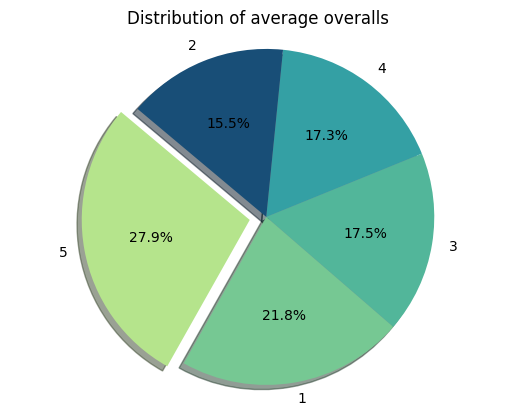

In [ ]:
# Visualize the distribution of average overalls
percentages = average_overalls_df['average_overalls'].value_counts(normalize=True) * 100
custom_colors = ['#B5E48C','#76C893','#52B69A','#34A0A4','#184E77']
labels = percentages.index.astype(str)
sizes = percentages.values
colors = custom_colors[0:len(labels)]
explode = (0.1, 0, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
ax1.axis('equal')
ax1.set_title('Distribution of average overalls')
plt.show()

<div style="direction:rtl; font-size: 25px; background-color: cyan; color:black; padding:30px 0">
بخش ۳) مدل تحلیل احساس
</div>

In [6]:
df_train_1 = df_train.dropna(subset=['vote'])
df_train_1

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
3,1,2,True,2016-01-01,A2G1GE7HI6EVEG,B008GVOVK0,{'Color:': ' Full HD 1080P'},Brad M.,"After receiving this, I plugged in my Amazon F...",Lemon!,1451606400
4,1,25,True,2016-01-01,A3BQPI44W1WLMJ,B008GVOVK0,{'Color:': ' Full HD 1080P'},Robert Baxter,I'm fairly good with tech stuff. For such a si...,Not working,1451606400
5,5,25,False,2016-01-01,A1NGUU2XF63XPE,B017VT30G8,{'Color:': ' Green'},niki,This is a review of SkyGenius Bluetooth headph...,Great budget Bluetooth headphones - sound far ...,1451606400
7,5,7,False,2016-01-01,A2ZRUU2Z75GKPV,B018U6YUWE,{'Color:': ' white/gold'},DebraP,I was excited to get this at a reduced price f...,Love This Wireless Headphones,1451606400
8,2,3,True,2016-01-01,A3E132EP0135J9,B011AJRSK4,{'Style:': ' V02'},Jon C.,"Their is no cable management what so ever, get...",Nightmare to work in,1451606400
...,...,...,...,...,...,...,...,...,...,...,...
490083,1,2,True,2018-09-16,A20SQ0KV1DE9AR,B01AWOAUJY,{'Size:': ' 160G'},Marty B.,I bought this computer exactly 4 months ago. ...,"These are OLD units, it's a HUGE risk!",1537056000
490091,5,2,True,2018-09-17,A3I32W4PS9KUPX,B01GLRX81I,"{'Size:': ' Real Boost Clock: 1784 MHz', 'Styl...",Jacob Budd,I spend a lot of time building/fixing desktop ...,Great card at an exceptional value,1537142400
490124,5,20,True,2018-09-17,A2Q3DORIX63LFD,B01F75U29G,{'Color:': ' Navy Blue'},Scott Stuart,Bought two of these for my college student twi...,Great College Backpack,1537142400
490149,1,5,True,2018-09-18,A10Z2KZF69WCKZ,B01G5HPXB2,{'Color:': ' A-White'},Pegan,I bought this based on all of the 5 star revie...,Doesn't work at all. Positive reviews are all ...,1537228800


In [14]:
import re

df_train_1 = df_train_1.copy()  # Create a copy of the DataFrame
df_train_1 = df_train_1[["reviewText",'overall','vote','summary']]
df_train_1["reviewText"] =df_train_1["reviewText"].astype(str)
df_train_1['reviewText_lower']=df_train_1["reviewText"].str.lower()
df_train_1.head()


,reviewText,overall,vote,summary,reviewText_lower
3,"After receiving this, I plugged in my Amazon F...",1,2,Lemon!,"after receiving this, i plugged in my amazon f..."
4,I'm fairly good with tech stuff. For such a si...,1,25,Not working,i'm fairly good with tech stuff. for such a si...
5,This is a review of SkyGenius Bluetooth headph...,5,25,Great budget Bluetooth headphones - sound far ...,this is a review of skygenius bluetooth headph...
8,"Their is no cable management what so ever, get...",2,3,Nightmare to work in,"their is no cable management what so ever, get..."
19,Extremely heavy duty bag to carry a whole LOT ...,5,2,Great extremely heavy duty lightstand bag that...,extremely heavy duty bag to carry a whole lot ...


In [15]:
# drop the new column created in last cell
import string

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df_train_1["reviewText_wo_punct"] = df_train_1["reviewText_lower"].apply(lambda text: remove_punctuation(text))
df_train_1.head()

,reviewText,overall,vote,summary,reviewText_lower,reviewText_wo_punct
3,"After receiving this, I plugged in my Amazon F...",1,2,Lemon!,"after receiving this, i plugged in my amazon f...",after receiving this i plugged in my amazon fi...
4,I'm fairly good with tech stuff. For such a si...,1,25,Not working,i'm fairly good with tech stuff. for such a si...,im fairly good with tech stuff for such a simp...
5,This is a review of SkyGenius Bluetooth headph...,5,25,Great budget Bluetooth headphones - sound far ...,this is a review of skygenius bluetooth headph...,this is a review of skygenius bluetooth headph...
8,"Their is no cable management what so ever, get...",2,3,Nightmare to work in,"their is no cable management what so ever, get...",their is no cable management what so ever gett...
19,Extremely heavy duty bag to carry a whole LOT ...,5,2,Great extremely heavy duty lightstand bag that...,extremely heavy duty bag to carry a whole lot ...,extremely heavy duty bag to carry a whole lot ...


In [16]:
from collections import Counter
cnt = Counter()
for text in df_train_1["reviewText_wo_punct"].values:
    for word in text.split():
        cnt[word] += 1

cnt.most_common(18)

[('the', 841555),
 ('i', 448393),
 ('to', 430011),
 ('and', 420917),
 ('a', 402285),
 ('it', 318426),
 ('is', 254405),
 ('of', 220206),
 ('this', 208659),
 ('for', 198171),
 ('in', 164924),
 ('that', 162288),
 ('my', 161514),
 ('with', 158140),
 ('on', 145218),
 ('you', 135894),
 ('but', 118467),
 ('have', 117421)]

In [17]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(18)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df_train_1["reviewText_wo_stopfreq"] = df_train_1["reviewText_wo_punct"].apply(lambda text: remove_freqwords(text))
df_train_1.head()

,reviewText,overall,vote,summary,reviewText_lower,reviewText_wo_punct,reviewText_wo_stopfreq
3,"After receiving this, I plugged in my Amazon F...",1,2,Lemon!,"after receiving this, i plugged in my amazon f...",after receiving this i plugged in my amazon fi...,after receiving plugged amazon firestick chrom...
4,I'm fairly good with tech stuff. For such a si...,1,25,Not working,i'm fairly good with tech stuff. for such a si...,im fairly good with tech stuff for such a simp...,im fairly good tech stuff such simple device s...
5,This is a review of SkyGenius Bluetooth headph...,5,25,Great budget Bluetooth headphones - sound far ...,this is a review of skygenius bluetooth headph...,this is a review of skygenius bluetooth headph...,review skygenius bluetooth headphones they arr...
8,"Their is no cable management what so ever, get...",2,3,Nightmare to work in,"their is no cable management what so ever, get...",their is no cable management what so ever gett...,their no cable management what so ever getting...
19,Extremely heavy duty bag to carry a whole LOT ...,5,2,Great extremely heavy duty lightstand bag that...,extremely heavy duty bag to carry a whole lot ...,extremely heavy duty bag to carry a whole lot ...,extremely heavy duty bag carry whole lot light...


In [18]:
# Drop the two columns which are no more needed
df_train_1.drop(["reviewText_wo_punct",'reviewText_lower'], axis=1, inplace=True)

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df_train_1["reviewText_wo_stopfreqrare"] = df_train_1["reviewText_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
df_train_1.head()

,reviewText,overall,vote,summary,reviewText_wo_stopfreq,reviewText_wo_stopfreqrare
3,"After receiving this, I plugged in my Amazon F...",1,2,Lemon!,after receiving plugged amazon firestick chrom...,after receiving plugged amazon firestick chrom...
4,I'm fairly good with tech stuff. For such a si...,1,25,Not working,im fairly good tech stuff such simple device s...,im fairly good tech stuff such simple device s...
5,This is a review of SkyGenius Bluetooth headph...,5,25,Great budget Bluetooth headphones - sound far ...,review skygenius bluetooth headphones they arr...,review skygenius bluetooth headphones they arr...
8,"Their is no cable management what so ever, get...",2,3,Nightmare to work in,their no cable management what so ever getting...,their no cable management what so ever getting...
19,Extremely heavy duty bag to carry a whole LOT ...,5,2,Great extremely heavy duty lightstand bag that...,extremely heavy duty bag carry whole lot light...,extremely heavy duty bag carry whole lot light...


In [23]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df_train_1["reviewText_lemmatized"] = df_train_1["reviewText_wo_stopfreqrare"].apply(lambda text: lemmatize_words(text))
df_train_1.head()


,reviewText,overall,vote,summary,reviewText_wo_stopfreq,reviewText_wo_stopfreqrare,reviewText_lemmatized
3,"After receiving this, I plugged in my Amazon F...",1,2,Lemon!,after receiving plugged amazon firestick chrom...,after receiving plugged amazon firestick chrom...,after receive plug amazon firestick chromecast...
4,I'm fairly good with tech stuff. For such a si...,1,25,Not working,im fairly good tech stuff such simple device s...,im fairly good tech stuff such simple device s...,im fairly good tech stuff such simple device s...
5,This is a review of SkyGenius Bluetooth headph...,5,25,Great budget Bluetooth headphones - sound far ...,review skygenius bluetooth headphones they arr...,review skygenius bluetooth headphones they arr...,review skygenius bluetooth headphone they arri...
8,"Their is no cable management what so ever, get...",2,3,Nightmare to work in,their no cable management what so ever getting...,their no cable management what so ever getting...,their no cable management what so ever get mot...
19,Extremely heavy duty bag to carry a whole LOT ...,5,2,Great extremely heavy duty lightstand bag that...,extremely heavy duty bag carry whole lot light...,extremely heavy duty bag carry whole lot light...,extremely heavy duty bag carry whole lot light...


In [ ]:
from textblob import TextBlob

def analyze_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity >= 0.05:
        return 'positive'
    elif analysis.sentiment.polarity <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df_train_1['sentiment'] = df_train_1["summary"].apply(analyze_sentiment)
df_train_1.head()


,reviewText,overall,vote,summary,reviewText_wo_stopfreq,reviewText_wo_stopfreqrare,sentiment
3,"After receiving this, I plugged in my Amazon F...",1,2,Lemon!,after receiving plugged amazon firestick chrom...,after receiving plugged amazon firestick chrom...,neutral
4,I'm fairly good with tech stuff. For such a si...,1,25,Not working,im fairly good tech stuff such simple device s...,im fairly good tech stuff such simple device s...,neutral
5,This is a review of SkyGenius Bluetooth headph...,5,25,Great budget Bluetooth headphones - sound far ...,review skygenius bluetooth headphones they arr...,review skygenius bluetooth headphones they arr...,positive
7,I was excited to get this at a reduced price f...,5,7,Love This Wireless Headphones,was excited get at reduced price review purpos...,was excited get at reduced price review purpos...,positive
8,"Their is no cable management what so ever, get...",2,3,Nightmare to work in,their no cable management what so ever getting...,their no cable management what so ever getting...,neutral


In [ ]:
sentiment_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
df_train_1['sentiment'] = df_train_1['sentiment'].map(sentiment_dict)
df_train_1.head()

,reviewText,overall,vote,summary,reviewText_wo_stopfreq,reviewText_wo_stopfreqrare,sentiment
3,"After receiving this, I plugged in my Amazon F...",1,2,Lemon!,after receiving plugged amazon firestick chrom...,after receiving plugged amazon firestick chrom...,1
4,I'm fairly good with tech stuff. For such a si...,1,25,Not working,im fairly good tech stuff such simple device s...,im fairly good tech stuff such simple device s...,1
5,This is a review of SkyGenius Bluetooth headph...,5,25,Great budget Bluetooth headphones - sound far ...,review skygenius bluetooth headphones they arr...,review skygenius bluetooth headphones they arr...,2
7,I was excited to get this at a reduced price f...,5,7,Love This Wireless Headphones,was excited get at reduced price review purpos...,was excited get at reduced price review purpos...,2
8,"Their is no cable management what so ever, get...",2,3,Nightmare to work in,their no cable management what so ever getting...,their no cable management what so ever getting...,1


In [8]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    # Remove punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove stop words
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    # Combine tokens into a new text
    processed_text = ' '.join(tokens)
    return processed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import f1_score

# Preprocessing variables and number of classes
max_length = 128
num_classes = 5

# Create an instance of the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
val_size = int(len(df_train_1) * 0.2)
df_val = df_train_1.sample(val_size, random_state=42)
df_train_1 = df_train_1.drop(df_val.index)

# Data preparation section
train_texts = df_train_1['reviewText'].apply(preprocess_text).tolist()
train_labels = df_train_1['overall'].tolist()

val_texts = df_val['reviewText'].apply(preprocess_text).tolist()
val_labels = df_val['overall'].tolist()

test_texts = df_test['reviewText'].apply(preprocess_text).tolist()

# Text preprocessing using the tokenizer
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')

# Create data loaders
train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_labels))
val_dataset = TensorDataset(val_encodings.input_ids, val_encodings.attention_mask, torch.tensor(val_labels))
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Create an instance of the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Create an instance of the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Training loop
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels': torch.tensor([label - 1 for label in batch[2]], dtype=torch.long).to(device)}

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)

    # Evaluating the model on validation data
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {'input_ids': batch[0].to(device),
                      'attention_mask': batch[1].to(device),
                      'labels': torch.tensor([label - 1 for label in batch[2]], dtype=torch.long).to(device)}

            outputs = model(**inputs)
            val_loss += outputs.loss.item()
            predictions.extend(torch.argmax(outputs.logits, dim=1).tolist())
            true_labels.extend(inputs['labels'].tolist())

    avg_val_loss = val_loss / len(val_loader)
    micro_f1_val = f1_score(true_labels, predictions, average='micro')

    # Evaluating the model on training data
    model.eval()
    train_predictions = []
    true_train_labels = []

    with torch.no_grad():
        for batch in train_loader:
            inputs = {'input_ids': batch[0].to(device),
                      'attention_mask': batch[1].to(device),
                      'labels': torch.tensor([label - 1 for label in batch[2]], dtype=torch.long).to(device)}

            outputs = model(**inputs)
            train_predictions.extend(torch.argmax(outputs.logits, dim=1).tolist())
            true_train_labels.extend(inputs['labels'].tolist())

    micro_f1_train = f1_score(true_train_labels, train_predictions, average='micro')

    print(f'Epoch {epoch + 1}:')
    print(f'  Training Loss: {avg_train_loss:.4f}')
    print(f'  Validation Loss: {avg_val_loss:.4f}')
    print(f'  Training Micro F1 Score: {micro_f1_train:.4f}')
    print(f'  Validation Micro F1 Score: {micro_f1_val:.4f}')

    torch.save(model.state_dict(), f'model_weights_epoch_{epoch + 1}.pth')

Epoch 1:
  Training Loss: 0.8812
  Validation Loss: 0.7987
  Training Micro F1 Score: 0.7296
  Validation Micro F1 Score: 0.6942
Epoch 2:
  Training Loss: 0.6996
  Validation Loss: 0.8125
  Training Micro F1 Score: 0.7818
  Validation Micro F1 Score: 0.7034
Epoch 3:
  Training Loss: 0.5596
  Validation Loss: 0.8251
  Training Micro F1 Score: 0.8657
  Validation Micro F1 Score: 0.6994
Epoch 4:
  Training Loss: 0.4298
  Validation Loss: 0.9092
  Training Micro F1 Score: 0.9091
  Validation Micro F1 Score: 0.7082
Epoch 5:
  Training Loss: 0.3243
  Validation Loss: 1.0402
  Training Micro F1 Score: 0.9342
  Validation Micro F1 Score: 0.6987


In [13]:
# Set the model to evaluation mode
model.eval()
test_predictions = []

# Create an iterator for the test data
test_data_iter = iter(test_loader)

# Disable gradient computation during inference
with torch.no_grad():
    # Loop through the test data loader
    for _ in range(len(test_loader)):
        # Read a batch of test data
        batch = next(test_data_iter)

        # Prepare inputs for the model
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device)}

        # Make predictions on the test data
        outputs = model(**inputs)

        # Extend the list of test predictions with the model's predicted labels
        test_predictions.extend(torch.argmax(outputs.logits, dim=1).tolist())

# Create a DataFrame with the predicted labels and save it to a CSV file
submission_df = pd.DataFrame({'predicted': test_predictions})
submission_df.to_csv('q2_submission.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Assuming you have df_train with 'reviewText' and 'overall' columns
# Preprocess data
max_words = 5000
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train['reviewText'])
total_words = len(tokenizer.word_index) + 1

input_sequences = tokenizer.texts_to_sequences(df_train['reviewText'])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')

# Define the model
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_length))
model.add(LSTM(50))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the model
model.fit(input_sequences, df_train['overall'], epochs=5)

# Assuming you have df_test with 'reviewText'
input_sequences_test = tokenizer.texts_to_sequences(df_test['reviewText'])
input_sequences_test = pad_sequences(input_sequences_test, maxlen=max_sequence_length, padding='post')

# Predict sentiment
predicted_sentiment = model.predict(input_sequences_test)

df_test['predicted_sentiment'] = predicted_sentiment[:, 0]  # Assuming the first column contains the sentiment predictions
df_test


Epoch 1/5
15327/15327 [==============================] - 3925s 256ms/step - loss: 0.9005 - accuracy: 0.0955
Epoch 2/5
15327/15327 [==============================] - 3872s 253ms/step - loss: 0.7108 - accuracy: 0.0956
Epoch 3/5
15327/15327 [==============================] - 3877s 253ms/step - loss: 0.6501 - accuracy: 0.0956
Epoch 4/5
15327/15327 [==============================] - 3784s 247ms/step - loss: 0.6055 - accuracy: 0.0956
Epoch 5/5
625/625 [==============================] - 10s 16ms/step


,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,predicted_sentiment
0,<NA>,True,2016-01-01,A23UM38AS0MPVC,B00MGKZZHK,{'Color:': ' White'},Amazon Customer,Interesting concept. Could be expanded on and ...,"Great idea and concept, but not recommended. R...",1451606400,1.876756
1,<NA>,True,2016-01-01,A1ND27OEDSAL0F,B00GYFLO14,"{'Color:': ' Gunmetal', 'Product Packaging:': ...",Jake &amp; Robyn,I've been on a hunt for acceptable headphones ...,"Nice sound, vice grip (where is the large head...",1451606400,3.864954
2,3,True,2016-01-01,A1OLS3TMT1MJ9L,B000BFVI6O,NaN,some guy,This is a waste of money. Just look at your ca...,This is a waste of money,1451606400,1.243671
3,3,True,2016-01-01,A2TTDIU3R7P3AT,B00C8FBBJ4,NaN,Rich B,I bought this to burn my home videos to Blu-ra...,"Okay for BD burning, but poor playback of comm...",1451606400,2.270411
4,<NA>,False,2016-01-01,AA8RBTN3J2F5H,B014ULWTVC,{'Style:': ' HD28DSE'},R. Kent McVety,I was not satisfied with this projector. 94% ...,Returned the projector,1451606400,2.311237
...,...,...,...,...,...,...,...,...,...,...,...
19995,<NA>,True,2018-09-23,A3OQOPRRST29VX,B01EZ0X034,{'Size:': ' 128GB'},Kay Valle Ganev,The only issue with it is the it's flimsy... P...,Low quality materials,1537660800,1.552086
19996,<NA>,True,2018-09-24,A3EC7HG562LLLK,B01CH9ZTI4,NaN,C. Gregory,I absolutely love the colors of the monitor. ...,"Beautiful color, 4k resolution, but should be ...",1537747200,3.749489
19997,<NA>,True,2018-09-25,A3CTZ5C8HDU3F2,B01EML8W34,{'Color:': ' Rose'},Kiser273,Got this for my Granddaughter. She goes everyw...,Soft case with handle,1537833600,4.577205
19998,<NA>,True,2018-09-28,AU6O1OSB36LQP,B01H8L4EM8,"{'Size:': ' S', 'Color:': ' Grey', 'Number of ...",Glenn,I have 3 model 3B Pis that run 25/7 in these c...,Great for use in adverse environments,1538092800,4.637603


In [ ]:
from textblob import TextBlob

def analyze_sentiment(text):
    if isinstance(text, str):  # Check if text is a string
        analysis = TextBlob(text)
        if analysis.sentiment.polarity >= 0.05:
            return 'positive'
        elif analysis.sentiment.polarity <= -0.05:
            return 'negative'
        else:
            return 'neutral'
    else:
        return 'neutral'

df_test['sentiment'] = df_test["summary"].apply(analyze_sentiment)
df_test

,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,predicted_sentiment,sentiment
0,<NA>,True,2016-01-01,A23UM38AS0MPVC,B00MGKZZHK,{'Color:': ' White'},Amazon Customer,Interesting concept. Could be expanded on and ...,"Great idea and concept, but not recommended. R...",1451606400,1.876756,positive
1,<NA>,True,2016-01-01,A1ND27OEDSAL0F,B00GYFLO14,"{'Color:': ' Gunmetal', 'Product Packaging:': ...",Jake &amp; Robyn,I've been on a hunt for acceptable headphones ...,"Nice sound, vice grip (where is the large head...",1451606400,3.864954,positive
2,3,True,2016-01-01,A1OLS3TMT1MJ9L,B000BFVI6O,NaN,some guy,This is a waste of money. Just look at your ca...,This is a waste of money,1451606400,1.243671,negative
3,3,True,2016-01-01,A2TTDIU3R7P3AT,B00C8FBBJ4,NaN,Rich B,I bought this to burn my home videos to Blu-ra...,"Okay for BD burning, but poor playback of comm...",1451606400,2.270411,neutral
4,<NA>,False,2016-01-01,AA8RBTN3J2F5H,B014ULWTVC,{'Style:': ' HD28DSE'},R. Kent McVety,I was not satisfied with this projector. 94% ...,Returned the projector,1451606400,2.311237,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,<NA>,True,2018-09-23,A3OQOPRRST29VX,B01EZ0X034,{'Size:': ' 128GB'},Kay Valle Ganev,The only issue with it is the it's flimsy... P...,Low quality materials,1537660800,1.552086,neutral
19996,<NA>,True,2018-09-24,A3EC7HG562LLLK,B01CH9ZTI4,NaN,C. Gregory,I absolutely love the colors of the monitor. ...,"Beautiful color, 4k resolution, but should be ...",1537747200,3.749489,positive
19997,<NA>,True,2018-09-25,A3CTZ5C8HDU3F2,B01EML8W34,{'Color:': ' Rose'},Kiser273,Got this for my Granddaughter. She goes everyw...,Soft case with handle,1537833600,4.577205,positive
19998,<NA>,True,2018-09-28,AU6O1OSB36LQP,B01H8L4EM8,"{'Size:': ' S', 'Color:': ' Grey', 'Number of ...",Glenn,I have 3 model 3B Pis that run 25/7 in these c...,Great for use in adverse environments,1538092800,4.637603,positive


In [ ]:
sentiment_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
df_train_1['sentiment'] = df_train_1['sentiment'].map(sentiment_dict)

In [ ]:
df_test['predicted_sentiment'] = predicted_sentiment[:, 0]  # Assuming the first column contains the sentiment predictions
df_test

,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,predicted_sentiment
0,<NA>,True,2016-01-01,A23UM38AS0MPVC,B00MGKZZHK,{'Color:': ' White'},Amazon Customer,Interesting concept. Could be expanded on and ...,"Great idea and concept, but not recommended. R...",1451606400,0.333302
1,<NA>,True,2016-01-01,A1ND27OEDSAL0F,B00GYFLO14,"{'Color:': ' Gunmetal', 'Product Packaging:': ...",Jake &amp; Robyn,I've been on a hunt for acceptable headphones ...,"Nice sound, vice grip (where is the large head...",1451606400,0.333283
2,3,True,2016-01-01,A1OLS3TMT1MJ9L,B000BFVI6O,NaN,some guy,This is a waste of money. Just look at your ca...,This is a waste of money,1451606400,0.333302
3,3,True,2016-01-01,A2TTDIU3R7P3AT,B00C8FBBJ4,NaN,Rich B,I bought this to burn my home videos to Blu-ra...,"Okay for BD burning, but poor playback of comm...",1451606400,0.333321
4,<NA>,False,2016-01-01,AA8RBTN3J2F5H,B014ULWTVC,{'Style:': ' HD28DSE'},R. Kent McVety,I was not satisfied with this projector. 94% ...,Returned the projector,1451606400,0.333263
...,...,...,...,...,...,...,...,...,...,...,...
19995,<NA>,True,2018-09-23,A3OQOPRRST29VX,B01EZ0X034,{'Size:': ' 128GB'},Kay Valle Ganev,The only issue with it is the it's flimsy... P...,Low quality materials,1537660800,0.333303
19996,<NA>,True,2018-09-24,A3EC7HG562LLLK,B01CH9ZTI4,NaN,C. Gregory,I absolutely love the colors of the monitor. ...,"Beautiful color, 4k resolution, but should be ...",1537747200,0.333345
19997,<NA>,True,2018-09-25,A3CTZ5C8HDU3F2,B01EML8W34,{'Color:': ' Rose'},Kiser273,Got this for my Granddaughter. She goes everyw...,Soft case with handle,1537833600,0.333313
19998,<NA>,True,2018-09-28,AU6O1OSB36LQP,B01H8L4EM8,"{'Size:': ' S', 'Color:': ' Grey', 'Number of ...",Glenn,I have 3 model 3B Pis that run 25/7 in these c...,Great for use in adverse environments,1538092800,0.333292
